# Определение токсичности комментариев

<h1>Оглавление<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Введение" data-toc-modified-id="Введение-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Введение</a></span><ul class="toc-item"><li><span><a href="#Описание-проекта" data-toc-modified-id="Описание-проекта-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Описание проекта</a></span></li><li><span><a href="#Цель-исследования" data-toc-modified-id="Цель-исследования-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Цель исследования</a></span></li><li><span><a href="#План-исследования" data-toc-modified-id="План-исследования-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>План исследования</a></span></li></ul></li><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Подготовка данных</a></span></li><li><span><a href="#Обучение-моделей" data-toc-modified-id="Обучение-моделей-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение моделей</a></span><ul class="toc-item"><li><span><a href="#LogisticRegression" data-toc-modified-id="LogisticRegression-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>LogisticRegression</a></span></li><li><span><a href="#DecisionTreeClassifier" data-toc-modified-id="DecisionTreeClassifier-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>DecisionTreeClassifier</a></span></li><li><span><a href="#SGDClassifier" data-toc-modified-id="SGDClassifier-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>SGDClassifier</a></span></li></ul></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Выводы</a></span></li></ul></div>

## Введение

### Описание проекта

Интернет-магазин запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

### Цель исследования
Построение модели для классификации комментариев пользователей на позитивные и негативные. 

Целевая метрика - `F1`, на тестовой выборке должна быть не менее 0,75.

### План исследования

1. Подготовка данных для исследования
* Загрузка данных для исследования из csv-файла.
* О качестве данных информации нет, поэтому прежде чем приступать к исследованию проведем обзор данных.
* Преобработка и подготовка данных:

    * проверка данных на наличие пропусков и дубликатов
    * предобработка текста для его дальнейшей подачи с модель перевода слов векторное представление:
        * токенизация
        * лематизация
        * очистка отт стоп-слов и лишних символов
        * добавление маркеров начала и конца списка
    * перевод в векторное представление
    * подготовка выборок данных для построения моделей.

2. Построение моделей машинного обучения и подбор лучших гиперпараметров для них:

 * `LogisticRegression`
 * `DecisionTreeClassifier`
 * `SGDClassifier`
 * `LGBMClassifier`

 Выбор лучшей модели по заданным характеристикам

3. Тестирование выбранной модели и оценка результатов.

4. Оформление выводов по результатам исследования

## Подготовка данных

In [1]:
# установка лемматизатора
#!pip install textblob

In [2]:
# импорт библиотек для выполения проекта
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords

nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

# графика
import seaborn as sns
import matplotlib.pyplot as plt

# импортируем функции и метрики из библиотеки sklearn
from sklearn.model_selection import (train_test_split,
                                     GridSearchCV)

from sklearn.linear_model import (LogisticRegression,
                                  SGDClassifier)
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier

from sklearn.dummy import DummyClassifier
from sklearn.feature_extraction.text import (CountVectorizer,
                                             TfidfTransformer)

from sklearn.metrics import (f1_score, classification_report,
                             confusion_matrix, ConfusionMatrixDisplay,
                             roc_curve)

# импортируем градиентные бустинги
from lightgbm import LGBMClassifier

# импортируем лемматизатор
from textblob import TextBlob

# предупреждения
import warnings
warnings.filterwarnings('ignore')

# статус процесса
from tqdm import tqdm
tqdm.pandas()
from datetime import datetime as dt

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Lana\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Lana\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Lana\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [3]:
# настроим отображение чисел и таблиц
#pd.set_option('display.float_format', '{:.4f}'.format)
pd.set_option('display.max_columns', 1000)
pd.set_option('max_colwidth', 1000)
pd.set_option('display.width', 500)
# выберем общее формление для графиков
sns.set(style="white", palette="Spectral")

In [4]:
try:
    df = pd.read_csv('./toxic_comments.csv')
except FileNotFoundError:
    df = pd.read_csv('/datasets/toxic_comments.csv.')

In [5]:
# зафиксируем псевдослучайность random_state
RS = 2023
# количество фолдов для кросс-валидации
CV = 3
# стоп-слова
SW = set(stopwords.words('english'))

In [6]:
def data_info(data_name):
    '''функция выводит информацию о данных'''
    
    print('\n\nДанные из выборки\n')
    display(data_name.head(5))
    display(data_name.tail(5))
    
    print('-'*60)
    print(f'\n\nКоличество признаков: {data_name.shape[1]}, Количество наблюдений: {data_name.shape[0]}\n')
    print('-'*60)
    print('\nИнформация о данных\n')
    info_list = []
    for item in data_name.columns:
        info_list.append({
            'Признак': item,
            'Тип данных': data_name.dtypes[item],
            'Уникальных значений': data_name[item].nunique(),
            '%Пропусков': data_name[item].isna().mean()*100
        })
    display(pd.DataFrame(info_list))
    print('-'*60)
 
    print(f'\n\nКоличество полных дубликатов в данных: {data_name.duplicated().sum()}')  

In [7]:
def clear_text(text):
    '''функция очистки текста 
    на входе: текст
    на выходе: очищенный от всего кроме букв текст без лишних пробелов'''
    text = text.lower()
    text = re.sub(r'[^a-z]', ' ', text) 
    text = re.sub('\s{2,}', ' ', text)
    
    split_list = text.split()
    clear_text = ' '.join(split_list)
    return clear_text

In [8]:
def del_stop_words(text):
    '''функция очистки текста от стоп-слов'''
    words = TextBlob(text)
    text_without_sw = [word for word in words.words if not word in SW]
    return " ".join(text_without_sw)

In [9]:
def lemmatize_with_postag(text):
    '''функция лематизации текста'''
    sentence = TextBlob(text)
    tag_dict = {"J": 'a', 
                "N": 'n', 
                "V": 'v', 
                "R": 'r'}
    words_and_tags = [(w, tag_dict.get(pos[0], 'n')) for w, pos in sentence.tags]    
    lemmatized_list = [wd.lemmatize(tag) for wd, tag in words_and_tags]
    return " ".join(lemmatized_list)

In [73]:
def best_model(model, params, features, target):
    '''функция подбора гиперпараметров для заданной модели
    на входе: модель, параметры для подбора, фичи и таргет
              способ подбора параметров, по умолчанию GridSearchCV
    на выходе: подобранная модель и значение искомой метрики F1'''
      
     
    # собираем пайплайн    
    pipe = Pipeline([
        ('vect', CountVectorizer(stop_words={'english'})),
        ('tfidf', TfidfTransformer()),
        ('clf', model)])  
    
    # подбор гиперпараметров
    searcher = GridSearchCV(pipe,
                            param_grid=params,
                            scoring='f1',
                            cv=CV,
                            n_jobs=-1,
                            verbose=True)
   
    search = searcher.fit(features, target)
     
        
    list_best_params.append({'model': search.best_estimator_[-1],
                             'best_estimator': search.best_estimator_,
                             'pipe_params': search.best_params_,
                             'F1': abs(search.best_score_),
                             'time_fit': search.refit_time_})

In [74]:
def print_result(list_for_print):
    '''выводим таблицу с данными'''
    # табличка с оптимизированными гиперпараметрами
    df_best_models = pd.DataFrame(list_for_print)
    display(df_best_models)

Приступим к осмотру данных

In [12]:
data_info(df)



Данные из выборки



,Unnamed: 0,text,toxic
0,0,"Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27",0
1,1,"D'aww! He matches this background colour I'm seemingly stuck with. Thanks. (talk) 21:51, January 11, 2016 (UTC)",0
2,2,"Hey man, I'm really not trying to edit war. It's just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page. He seems to care more about the formatting than the actual info.",0
3,3,"""\nMore\nI can't make any real suggestions on improvement - I wondered if the section statistics should be later on, or a subsection of """"types of accidents"""" -I think the references may need tidying so that they are all in the exact same format ie date format etc. I can do that later on, if no-one else does first - if you have any preferences for formatting style on references or want to do it yourself please let me know.\n\nThere appears to be a backlog on articles for review so I guess there may be a delay until a reviewer turns up. It's listed in the relevant form eg Wikipedia:Good_article_nominations#Transport """,0
4,4,"You, sir, are my hero. Any chance you remember what page that's on?",0


,Unnamed: 0,text,toxic
159287,159446,""":::::And for the second time of asking, when your view completely contradicts the coverage in reliable sources, why should anyone care what you feel? You can't even give a consistent argument - is the opening only supposed to mention significant aspects, or the """"most significant"""" ones? \n\n""",0
159288,159447,You should be ashamed of yourself \n\nThat is a horrible thing you put on my talk page. 128.61.19.93,0
159289,159448,"Spitzer \n\nUmm, theres no actual article for prostitution ring. - Crunch Captain.",0
159290,159449,And it looks like it was actually you who put on the speedy to have the first version deleted now that I look at it.,0
159291,159450,"""\nAnd ... I really don't think you understand. I came here and my idea was bad right away. What kind of community goes """"you have bad ideas"""" go away, instead of helping rewrite them. """,0


------------------------------------------------------------


Количество признаков: 3, Количество наблюдений: 159292

------------------------------------------------------------

Информация о данных



,Признак,Тип данных,Уникальных значений,%Пропусков
0,Unnamed: 0,int64,159292,0.0
1,text,object,159292,0.0
2,toxic,int64,2,0.0


------------------------------------------------------------


Количество полных дубликатов в данных: 0


Обзор данных показывает:
* у нас имеются три столбца
   - `Unnamed: 0` - похоже на ID комментария
   - `text` - текст комментария
   - `toxic` - целевой признак с разметкой токсичности комментариев
* мы имеем дело с англоязычным текстом
* пропусков, полных дубликатов  в данных нет
* в данных преставлено 159 292 записи

Учитывая вышеизложенное:
* удалим признак `Unnamed: 0`, так как он в нашем случае всего лишь дублирует индексацию
* проверим длину комментов на предмет их адекватности
* проверис баланс классов в целевом признаке

In [13]:
# удаляем столбец
df.drop('Unnamed: 0', axis=1, inplace=True);

In [14]:
length = df['text'].str.len()
print('Описательная статистика количества символов в поле `text`')
length.describe()

Описательная статистика количества символов в поле `text`


count    159292.000000
mean        393.691303
std         590.111825
min           5.000000
25%          95.000000
50%         205.000000
75%         435.000000
max        5000.000000
Name: text, dtype: float64

In [15]:
length.quantile(0.9)

889.0

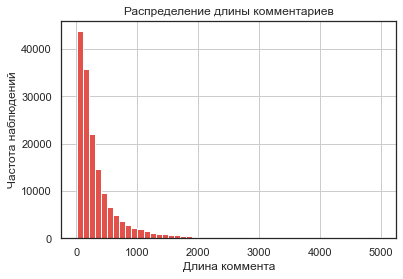

In [16]:
plt.figure(figsize=(6,4))
length.hist(bins=50);
plt.title('Распределение длины комментариев')
plt.xlabel('Длина коммента')
plt.ylabel('Частота наблюдений')
plt.show()

Если смотреть на имещиеся в сети данные о максимальной длине комментариев, то к примеру для Facebook это 7999 символов, для многих других сетей и сервисов и того больше. Таким образом, имеющиеся у нас коменты выглядят правдоподобными. Тем более, что 90% комментов укладываются в 1000 символов.

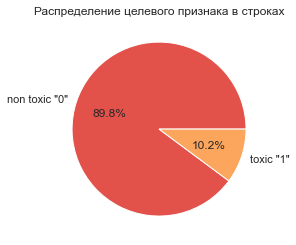

In [17]:
# построим круговую диаграмму распределения целевого признака
d_2 = df['toxic'].value_counts()

plt.figure(figsize=(8,4))
plt.title('Распределение целевого признака в строках')
plt.pie(d_2, labels={'non toxic "0"', 'toxic "1"'}, autopct='%.1f%%');
plt.show()

Таким образом, имеем явный дисбаланс классов. Это надо учитывать при делении на выборки и построении моделей.

В нашем случае задача классификации текстов сводится к моделированию в два этапа:
1. Модели перевода слов в векторное представление: исходные тексты преобразуются в векторы.
2. Модели классификации: на основе векторов текстов получаются прогнозы.

Прежде чем перейти к векторному представлению слов, необходимо провести предобработку текста:
 * токенизацию каждого текста, то есть его разбивку на слова;
 * лемматизацию: приведение к начальной словарной форме;
 * очищение текста от стоп-слов и ненужных символов;
 * добавление маркеров начала и конца предложения.

Затем полученные в ходе предобработки текста токены передадим модели, которая переводит их в векторные представления. 

А уже векторы передадим модели классификации для прогнозирования эмоциональной окраски текста — 0 («отрицательная») или 1 («положительная»).

Очистим текст от лишних знаков и приведем его к нижнему регистру и проведем лемматизацию

⚠️ Время лемматизации всей выборки составляет около 13 минут.

In [18]:
df['clear_text'] =  df['text'].progress_apply(
    lambda x: clear_text(str(x)))

100%|██████████| 159292/159292 [00:06<00:00, 23848.24it/s]


In [19]:
time_start = dt.now()
df['clear_text'] =  df['clear_text'].progress_apply(del_stop_words)
time_sw = (dt.now() - time_start)    
print(f'Время зачистки от стоп-слов всей выборки: {time_sw}')

100%|██████████| 159292/159292 [01:09<00:00, 2292.00it/s]

Время зачистки от стоп-слов всей выборки: 0:01:09.518158


In [20]:
time_start = dt.now()
df['lemma_text'] = df['clear_text'].progress_apply(lemmatize_with_postag)
time_lemm = (dt.now() - time_start)    
print(f'Время лемматизации всей выборки: {time_lemm}')

100%|██████████| 159292/159292 [09:45<00:00, 271.93it/s]

Время лемматизации всей выборки: 0:09:45.795425


In [21]:
df.head(5)

,text,toxic,clear_text,lemma_text
0,"Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27",0,explanation edits made username hardcore metallica fan reverted vandalisms closure gas voted new york dolls fac please remove template talk page since retired,explanation edits make username hardcore metallica fan revert vandalisms closure gas vote new york doll fac please remove template talk page since retire
1,"D'aww! He matches this background colour I'm seemingly stuck with. Thanks. (talk) 21:51, January 11, 2016 (UTC)",0,aww matches background colour seemingly stuck thanks talk january utc,aww match background colour seemingly stuck thanks talk january utc
2,"Hey man, I'm really not trying to edit war. It's just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page. He seems to care more about the formatting than the actual info.",0,hey man really trying edit war guy constantly removing relevant information talking edits instead talk page seems care formatting actual info,hey man really try edit war guy constantly remove relevant information talk edits instead talk page seem care format actual info
3,"""\nMore\nI can't make any real suggestions on improvement - I wondered if the section statistics should be later on, or a subsection of """"types of accidents"""" -I think the references may need tidying so that they are all in the exact same format ie date format etc. I can do that later on, if no-one else does first - if you have any preferences for formatting style on references or want to do it yourself please let me know.\n\nThere appears to be a backlog on articles for review so I guess there may be a delay until a reviewer turns up. It's listed in the relevant form eg Wikipedia:Good_article_nominations#Transport """,0,make real suggestions improvement wondered section statistics later subsection types accidents think references may need tidying exact format ie date format etc later one else first preferences formatting style references want please let know appears backlog articles review guess may delay reviewer turns listed relevant form eg wikipedia good article nominations transport,make real suggestion improvement wonder section statistic later subsection type accident think reference may need tidy exact format ie date format etc later one else first preference format style reference want please let know appear backlog article review guess may delay reviewer turn list relevant form eg wikipedia good article nomination transport
4,"You, sir, are my hero. Any chance you remember what page that's on?",0,sir hero chance remember page,sir hero chance remember page


Учитывая объемность данных. проведем исследовательскую часть на выборке в 50 000 объектов.

In [22]:
df_sample = df.sample(n=50000, random_state=RS)
df_sample.shape

(50000, 4)

Проверим сохранилось ли распределение целевого признака

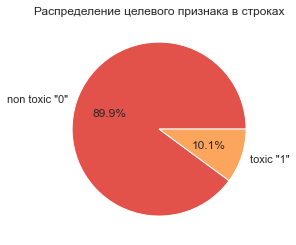

In [23]:
# построим круговую диаграмму распределения целевого признака
d_2 = df_sample['toxic'].value_counts()

plt.figure(figsize=(8,4))
plt.title('Распределение целевого признака в строках')
plt.pie(d_2, labels={'non toxic "0"', 'toxic "1"'}, autopct='%.1f%%');
plt.show()

Подготовим обучающую и тестовую выборки, не забывая про дисбаланс целевого признака

In [24]:
X, y = df_sample['lemma_text'], df_sample['toxic']
X.shape, y.shape

((50000,), (50000,))

In [25]:
(X_train, X_test, y_train, y_test) = train_test_split(X, y,
                                                      test_size=0.20,
                                                      random_state=RS, 
                                                      stratify=y) 

In [26]:
print(f'Размер тестовой выборки{y_test.shape}')

Размер тестовой выборки(10000,)


**Выводы:**

В ходе подготовительной части были выполнены следующие шаги:
* загружены данные и проведен их обзор
* в данных пропусков и убликатов не обнаружено
* выявлен дисбаланс классов в целевом признаке
* проведена предобработка теккста перед его подачей в модель машинного обучения
 * текст очищен от лишних символов
 * удалены стоп-слова
 * проведена лемматизация слов
* для дальнейшего исследования взята выборка в 50 000 объектов.
* подготовлены обучающая и тестовая выборки.


## Обучение моделей

Все модели будем обучать одним методом: в `Pipeline` последовательно будем использовать
 - `CountVectorizer` -  реализует как токенизацию, так и подсчет вхождений слова в одном корпусе
 - `TfidfTransformer` - осуществляет "взвешивание" слов
 - `Classificator` - модель классификации
    
    При подборе параметров будем руководствоваться документацией `Sklearn`.

### LogisticRegression

По классике жанра начнем подбор моделей с **LogisticRegression**:

In [75]:
# списко для агрегации результатов
list_best_params = []

In [76]:
# задаем модель
model_lr = LogisticRegression(class_weight='balanced')

В результате подбора гиперпараметров в проекте оставлены значения, которые не совпадают с дефолтными параметрами, и установлены наиблизжайшие значения, для минимизации времени работы алгоритма.

In [77]:
# гиперпараметры для поиска
params_lr = {
    'tfidf__sublinear_tf': (True, False),
    'clf__penalty': ['l2', 'l1'],   
    'clf__intercept_scaling': [0.1, 1, 3],
    'clf__C': [0.1, 11, 21]
         }

In [78]:
best_model(model_lr, params_lr, X_train, y_train)  

Fitting 3 folds for each of 36 candidates, totalling 108 fits


In [79]:
print_result(list_best_params)

,model,best_estimator,pipe_params,F1,time_fit
0,"LogisticRegression(C=21, class_weight='balanced', intercept_scaling=0.1)","(CountVectorizer(stop_words={'english'}), TfidfTransformer(sublinear_tf=True), LogisticRegression(C=21, class_weight='balanced', intercept_scaling=0.1))","{'clf__C': 21, 'clf__intercept_scaling': 0.1, 'clf__penalty': 'l2', 'tfidf__sublinear_tf': True}",0.762601,3.129515


### DecisionTreeClassifier

In [80]:
# задаем модель
model_dt = DecisionTreeClassifier(random_state=RS)

In [81]:
# гиперпараметры для поиска
params_dt = {
    'tfidf__smooth_idf': (True, False),
    'tfidf__norm': ['l1','l2'],
    'clf__max_depth': [None] + [6, 9],
    'clf__class_weight': [None, 'balanced']
          }

In [82]:
best_model(model_dt, params_dt, X_train, y_train)  

Fitting 3 folds for each of 24 candidates, totalling 72 fits


In [83]:
print_result(list_best_params)

,model,best_estimator,pipe_params,F1,time_fit
0,"LogisticRegression(C=21, class_weight='balanced', intercept_scaling=0.1)","(CountVectorizer(stop_words={'english'}), TfidfTransformer(sublinear_tf=True), LogisticRegression(C=21, class_weight='balanced', intercept_scaling=0.1))","{'clf__C': 21, 'clf__intercept_scaling': 0.1, 'clf__penalty': 'l2', 'tfidf__sublinear_tf': True}",0.762601,3.129515
1,DecisionTreeClassifier(random_state=2023),"(CountVectorizer(stop_words={'english'}), TfidfTransformer(norm='l1'), DecisionTreeClassifier(random_state=2023))","{'clf__class_weight': None, 'clf__max_depth': None, 'tfidf__norm': 'l1', 'tfidf__smooth_idf': True}",0.708321,109.764975


### SGDClassifier

В документации `Sklearn` при разборе работы с текстами рекомендуется для улучшения качества использоваться метод опорных векторов. В качестве более быстрого из алгоритмов используем стохастический градиентный спуск (`SGD`)

In [84]:
# задаем модель
model_sgd = SGDClassifier(random_state=RS)

In [85]:
# гиперпараметры для поиска
params_sgd = {
    'tfidf__smooth_idf': (True, False),
    'tfidf__sublinear_tf': (True, False),
    'tfidf__norm': ['l1','l2'],
    'clf__loss': ['hinge', 'modified_huber'],
    'clf__penalty': ['l1','l2'],
    'clf__alpha': [1e-05, 1e-04, 1e+03, 1e+04],
    'clf__class_weight': [None, 'balanced']
          }

In [86]:
best_model(model_sgd, params_sgd, X_train, y_train)  

Fitting 3 folds for each of 256 candidates, totalling 768 fits


In [87]:
print_result(list_best_params)

,model,best_estimator,pipe_params,F1,time_fit
0,"LogisticRegression(C=21, class_weight='balanced', intercept_scaling=0.1)","(CountVectorizer(stop_words={'english'}), TfidfTransformer(sublinear_tf=True), LogisticRegression(C=21, class_weight='balanced', intercept_scaling=0.1))","{'clf__C': 21, 'clf__intercept_scaling': 0.1, 'clf__penalty': 'l2', 'tfidf__sublinear_tf': True}",0.762601,3.129515
1,DecisionTreeClassifier(random_state=2023),"(CountVectorizer(stop_words={'english'}), TfidfTransformer(norm='l1'), DecisionTreeClassifier(random_state=2023))","{'clf__class_weight': None, 'clf__max_depth': None, 'tfidf__norm': 'l1', 'tfidf__smooth_idf': True}",0.708321,109.764975
2,"SGDClassifier(alpha=1e-05, penalty='l1', random_state=2023)","(CountVectorizer(stop_words={'english'}), TfidfTransformer(smooth_idf=False, sublinear_tf=True), SGDClassifier(alpha=1e-05, penalty='l1', random_state=2023))","{'clf__alpha': 1e-05, 'clf__class_weight': None, 'clf__loss': 'hinge', 'clf__penalty': 'l1', 'tfidf__norm': 'l2', 'tfidf__smooth_idf': False, 'tfidf__sublinear_tf': True}",0.772614,1.814416


**LGBMClassifier**

In [88]:
# подберем для каждой модификации гиперпараметры
# задаем модель
model_lgbm = LGBMClassifier(random_state=RS, n_jobs=-1)

# гиперпараметры для поиска
params_lgbm = {
    'tfidf__sublinear_tf': (True, False),
    'tfidf__norm': [None, 'l1','l2'], 
    'clf__n_estimators': [100, 200],
    'clf__learning_rate': [0.3, 0.4]
}

In [89]:
best_model(model_lgbm, params_lgbm, X_train, y_train)  

Fitting 3 folds for each of 24 candidates, totalling 72 fits


In [90]:
print_result(list_best_params)

,model,best_estimator,pipe_params,F1,time_fit
0,"LogisticRegression(C=21, class_weight='balanced', intercept_scaling=0.1)","(CountVectorizer(stop_words={'english'}), TfidfTransformer(sublinear_tf=True), LogisticRegression(C=21, class_weight='balanced', intercept_scaling=0.1))","{'clf__C': 21, 'clf__intercept_scaling': 0.1, 'clf__penalty': 'l2', 'tfidf__sublinear_tf': True}",0.762601,3.129515
1,DecisionTreeClassifier(random_state=2023),"(CountVectorizer(stop_words={'english'}), TfidfTransformer(norm='l1'), DecisionTreeClassifier(random_state=2023))","{'clf__class_weight': None, 'clf__max_depth': None, 'tfidf__norm': 'l1', 'tfidf__smooth_idf': True}",0.708321,109.764975
2,"SGDClassifier(alpha=1e-05, penalty='l1', random_state=2023)","(CountVectorizer(stop_words={'english'}), TfidfTransformer(smooth_idf=False, sublinear_tf=True), SGDClassifier(alpha=1e-05, penalty='l1', random_state=2023))","{'clf__alpha': 1e-05, 'clf__class_weight': None, 'clf__loss': 'hinge', 'clf__penalty': 'l1', 'tfidf__norm': 'l2', 'tfidf__smooth_idf': False, 'tfidf__sublinear_tf': True}",0.772614,1.814416
3,"LGBMClassifier(learning_rate=0.3, n_estimators=200, random_state=2023)","(CountVectorizer(stop_words={'english'}), TfidfTransformer(norm=None, sublinear_tf=True), LGBMClassifier(learning_rate=0.3, n_estimators=200, random_state=2023))","{'clf__learning_rate': 0.3, 'clf__n_estimators': 200, 'tfidf__norm': None, 'tfidf__sublinear_tf': True}",0.751722,4.723882


**Выводы:**

были исследованы следующие модели:
* `LogisticRegression`
* `DecisionTreeClassifier`
* `SGDClassifier`
* `LGBMClassifier`

Проведен подбор гиперпараметров

Лучшей моделью по установленной метрике `F1` оказался `SGDClassifier`, которые как раз был рекомендован в документации `sklearn`. Именно ее и проверим на тестовой выборке

# Тестирование

In [91]:
results = pd.DataFrame(list_best_params)
best_model = results['best_estimator'][2]

In [92]:
predicted = best_model.predict(X_test)
print(f'F1 на тестовой выборке: {f1_score(y_test, predicted):.2f}')

F1 на тестовой выборке: 0.80


In [93]:
# посмотрим отчет о метриках
print(classification_report(y_test, predicted))

              precision    recall  f1-score   support

           0       0.97      0.99      0.98      8989
           1       0.85      0.75      0.80      1011

    accuracy                           0.96     10000
   macro avg       0.91      0.87      0.89     10000
weighted avg       0.96      0.96      0.96     10000



* `Recall`- описывает, как хорошо модель разобралась в особенностях положительного класса и распознала его.
* `Precision` - выявляет, не переусердствует ли модель, присваивая положительные метки.
* `F1`- среднее гармоническое полноты и точности, так сказать "золотая середина" между `Recall` и `Precision`
* `Accuracy` – доля объектов, для которых мы правильно предсказали класс

Визуализируем `ConfusionMatrix` 

<Figure size 576x432 with 0 Axes>

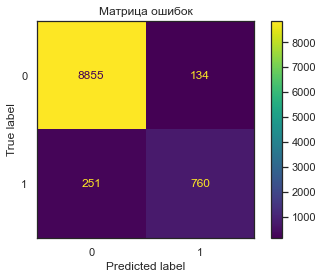

In [94]:
cm = confusion_matrix(y_test, predicted)
# confusion matrix
plt.figure(figsize=(8,6));

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title('Матрица ошибок')
plt.grid(False)
plt.show()

## Выводы

В ходе реализации проекта были выполнены следующие этапы:

1. загружены и изучены данные
2. проведена преобработка текста
    * очистка текста
    * лемматизация
3. данные разбиты на обучающую и тестовую выборки
4. Проведено построение моделей ML и подбор гиперпараметров.
При исследовании использовался `Pipeline`, в котором последовательно использовались векторизация `CountVectorizer`, `TFIDFTransformer` и классификаторы:
    * `LogisticRegression`
    * `DecisionTreeClassifier`
    * `SGDClassifier`
    * `LGBMClassifier`
 * подобраны лучшие гиперпараметры
 * выбрана лучшия модель для тестирования

5. Проверено качество лучшие модели на тестовой выборке.   

    В `SGDClassifier` при тестировании достугнут целевой уровень метрики `F1`.
* Итоговый показатель `F1` составил - 0.8. 

Судя по матрице ошибок, метрикам  наша тестовая модель совсем неплохо справляется с задачей.